In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt, log
sns.set_style("darkgrid")
from tqdm.notebook import tqdm, trange

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler  

In [4]:
prints = True

# Import des données

In [5]:
path = '../data/' 
hotels = pd.read_csv(path + '/features_hotels.csv')
data = pd.read_csv(path + 'data.csv')
data_test = pd.read_csv(path + 'test_set.csv')

In [6]:
# création de la colonne request_number dans le test set
data_test['request_number'] = 1
for avatar in np.unique(data_test['avatar_id']):
    data_test.loc[data_test['avatar_id'] == avatar, 'request_number'] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar])+1

In [7]:
data_test

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,request_number
0,0,1,vilnius,21,romanian,0,1,161,46,1
1,1,1,vilnius,21,romanian,0,1,187,32,1
2,2,1,vilnius,21,romanian,0,1,279,12,1
3,3,1,vilnius,21,romanian,0,1,395,10,1
4,4,1,vilnius,21,romanian,0,1,488,42,1
...,...,...,...,...,...,...,...,...,...,...
6639,6639,843,rome,5,irish,0,794,987,1,3
6640,6640,844,vienna,1,irish,1,794,26,1,4
6641,6641,844,vienna,1,irish,1,794,263,0,4
6642,6642,844,vienna,1,irish,1,794,456,0,4


In [8]:
# ajout des caractéristiques des hotels
data = data.merge(hotels, on=['hotel_id','city'])
data_test = data_test.merge(hotels, on=['hotel_id','city'])
data_test = data_test.sort_values('index')    

In [9]:
# suppression de la requête de l'avatar_id 134 qui pose problème
# print(data.loc[data.avatar_id == 134])
data = data.drop(index = data.loc[data.avatar_id == 134].index)

# Approche naïve

Ici on génère des prix en utilisant les requêtes les plus proches.

In [10]:
# y_pred = []

# for i in tqdm(data_test.index) :
#     _, order, city, date, lang, mob, avatar, hotel, stock, req, group, brand, park, pool, child = data_test.iloc[i].values
#     data_tmp = data.loc[data.hotel_id == hotel]
#     delta_date = data_tmp.date.values - date
    
#     y_pred.append(data_tmp.iloc[np.argmin(delta_date)].price)

# Mise en forme des données

In [11]:
colQT = ['request_number', 'stock', 'date','price']
colBool = ['mobile', 'pool', 'parking']
colQL = ['city', 'language', 'group', 'brand', 'children_policy']

In [12]:
for col in ['city', 'language', 'avatar_id', 'hotel_id', 'group', 'brand','children_policy','mobile','parking','pool'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)

## Transformation des variables QL en QT

> Transformer les dummies en QT

# Exploration

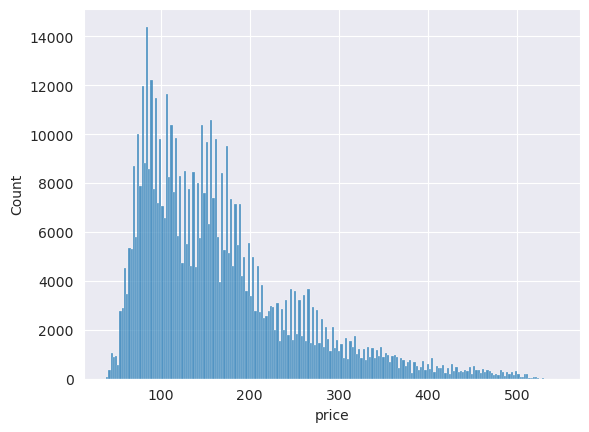

In [13]:
if prints :
    plt.figure()
    sns.histplot(data['price'])
    plt.show()

## Unidimensionnelle

### QL

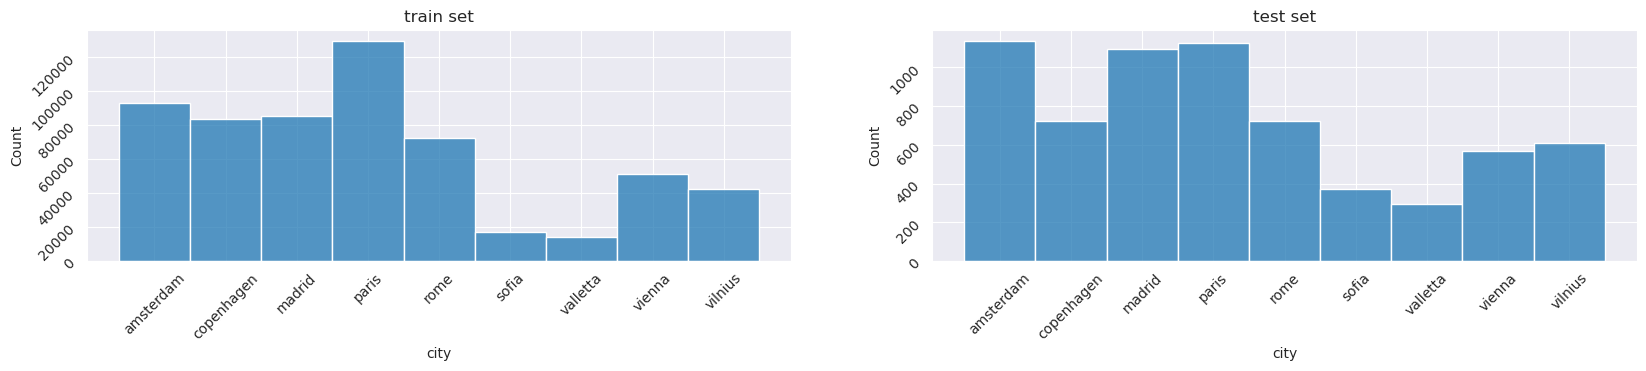

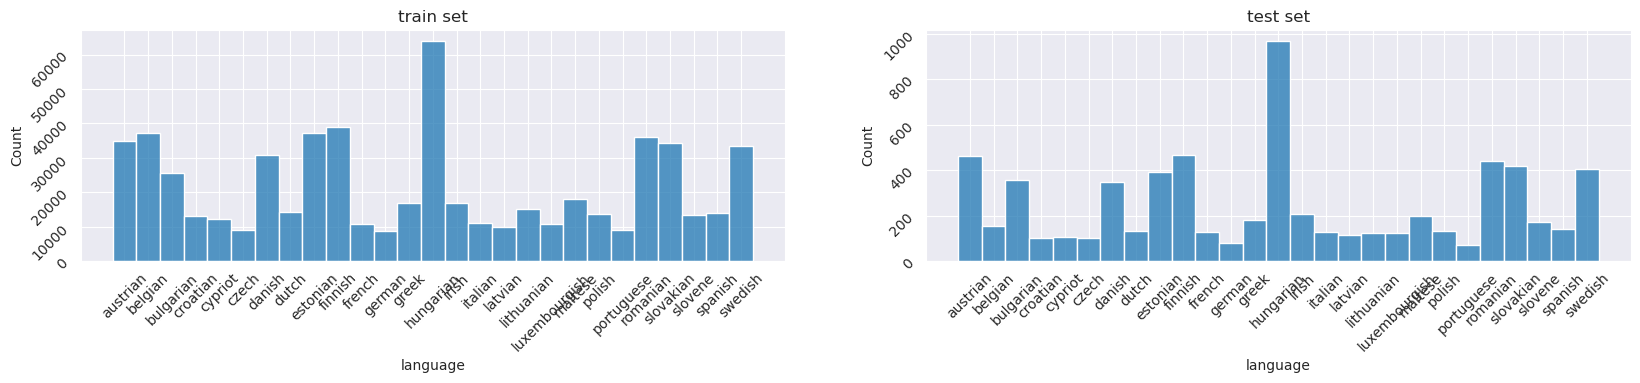

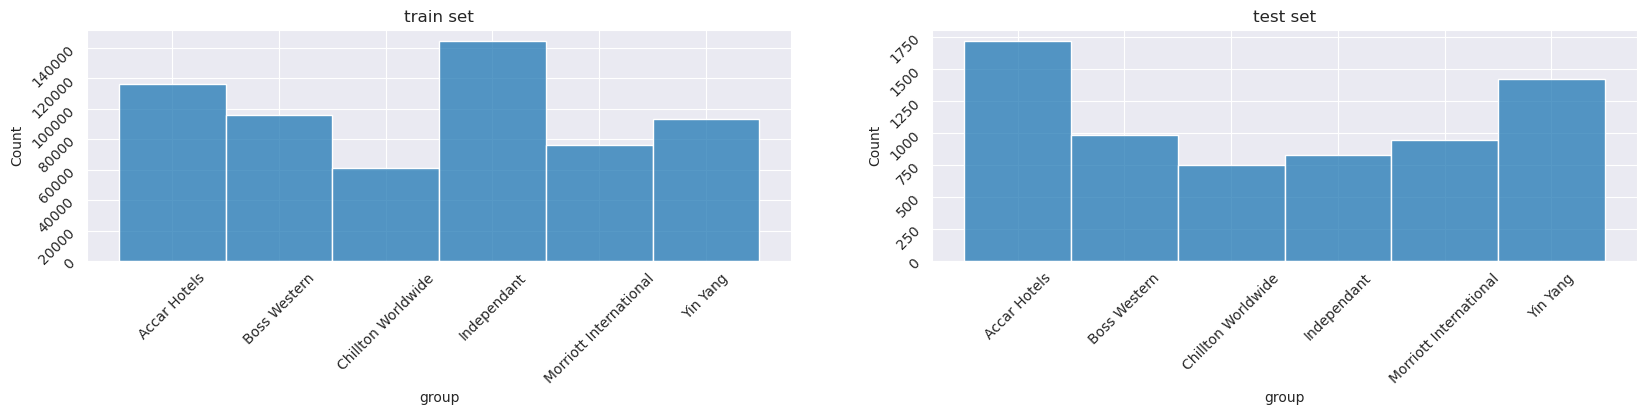

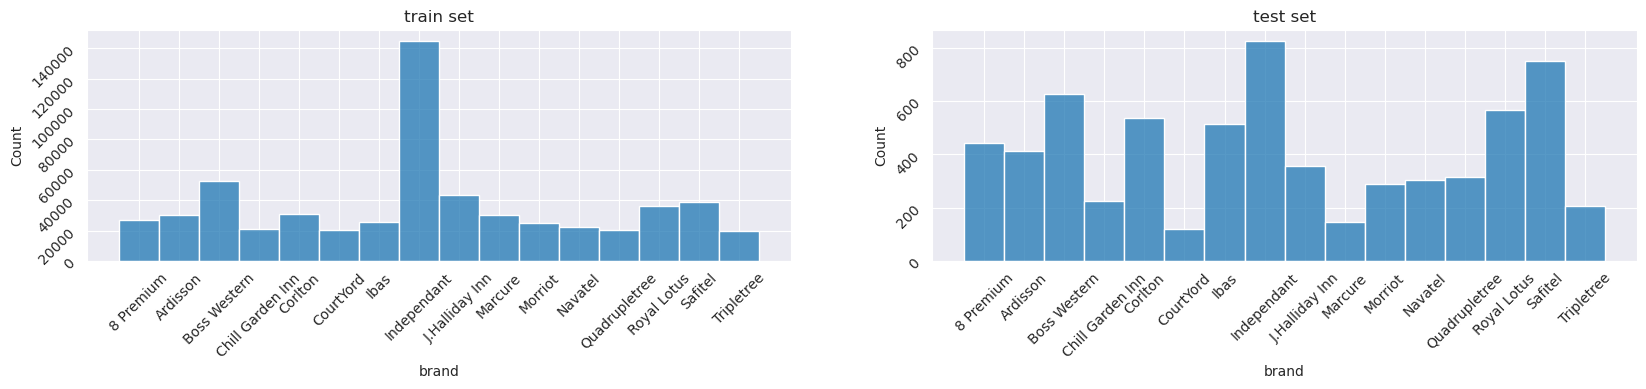

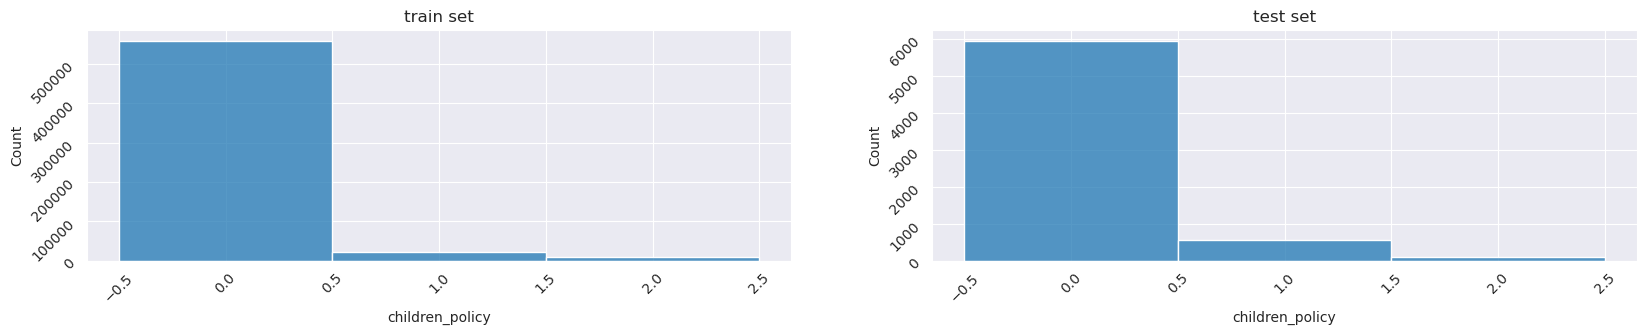

In [14]:
if prints :
    for col in colQL:
        fig, axes = plt.subplots(1, 2, figsize=(20, 3))
        sns.histplot(ax = axes[0], x = data[col])
        sns.histplot(ax = axes[1], x = data_test[col])
        axes[0].tick_params(labelrotation=45)
        axes[1].tick_params(labelrotation=45)
        axes[0].set_title('train set')
        axes[1].set_title('test set')
        plt.show()

### QT

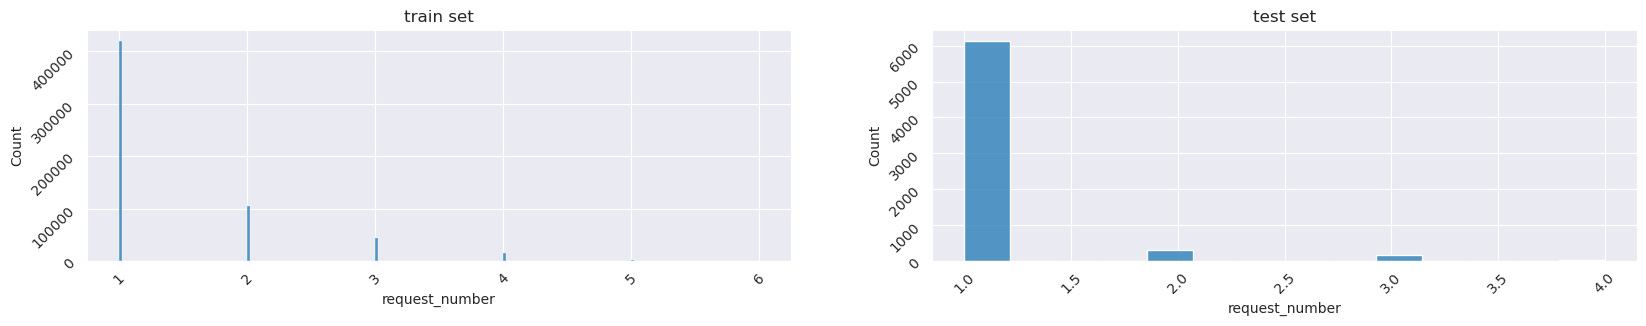

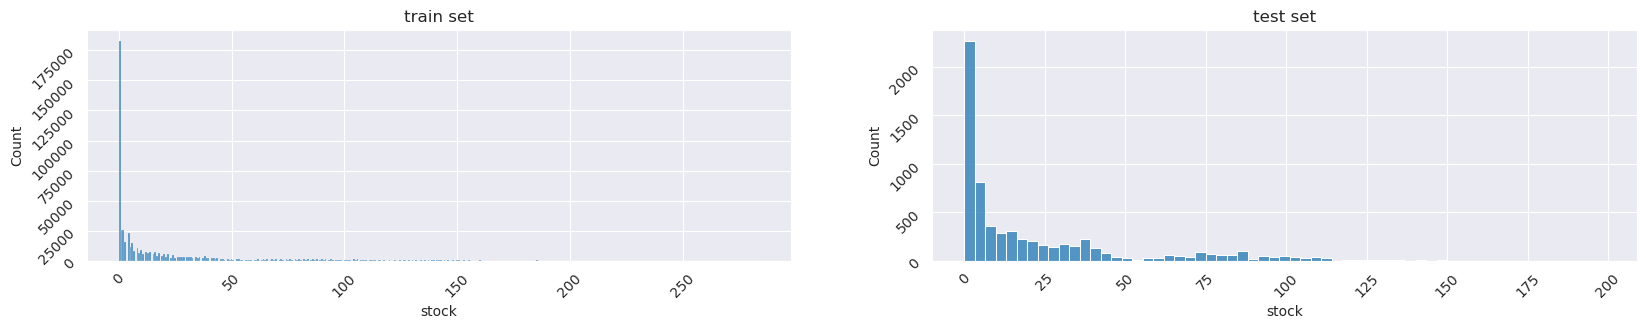

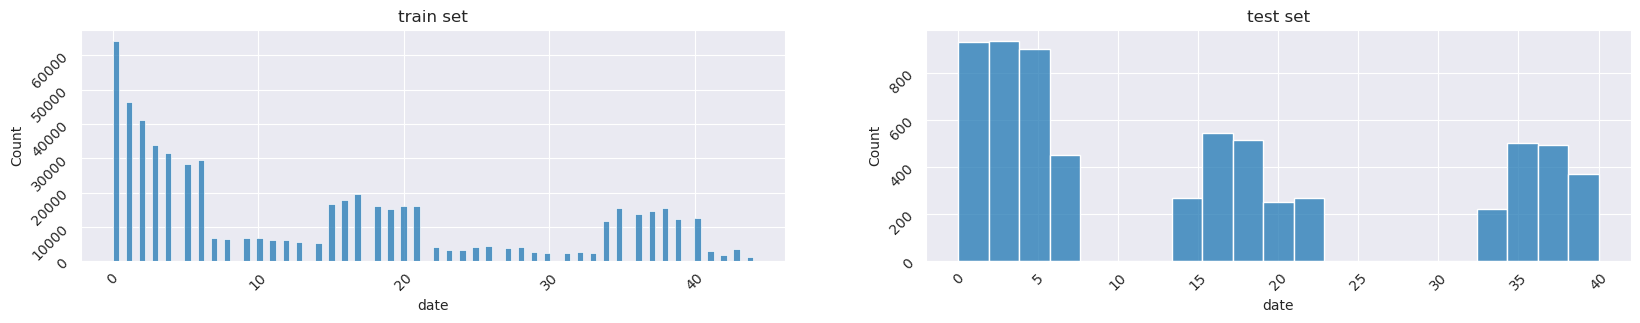

In [15]:
if prints :
    for col in colQT[:-1]:
        fig, axes = plt.subplots(1, 2, figsize=(20, 3))
        sns.histplot(ax = axes[0], x = data[col])
        sns.histplot(ax = axes[1], x = data_test[col])
        axes[0].tick_params(labelrotation=45)
        axes[1].tick_params(labelrotation=45)
        axes[0].set_title('train set')
        axes[1].set_title('test set')
        plt.show()

## Bidimensionnelle

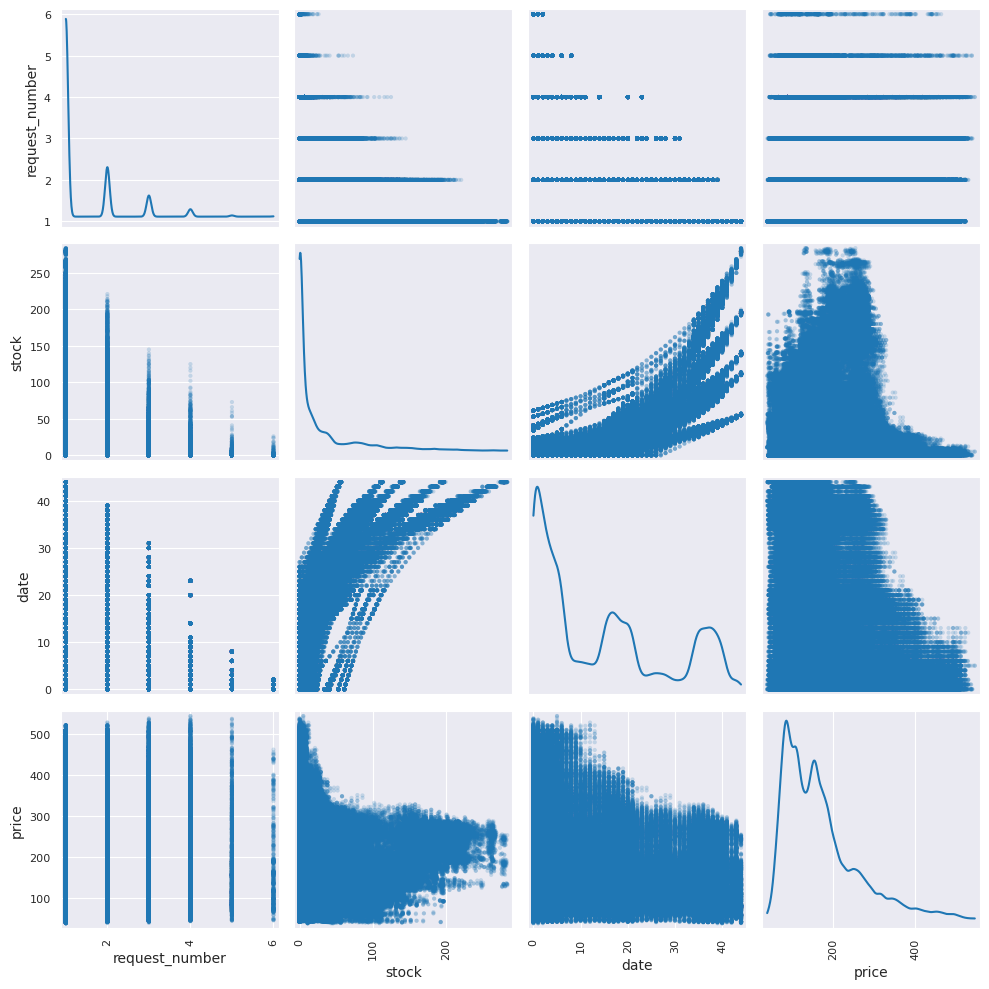

In [16]:
if prints :
    scatter_matrix(data[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

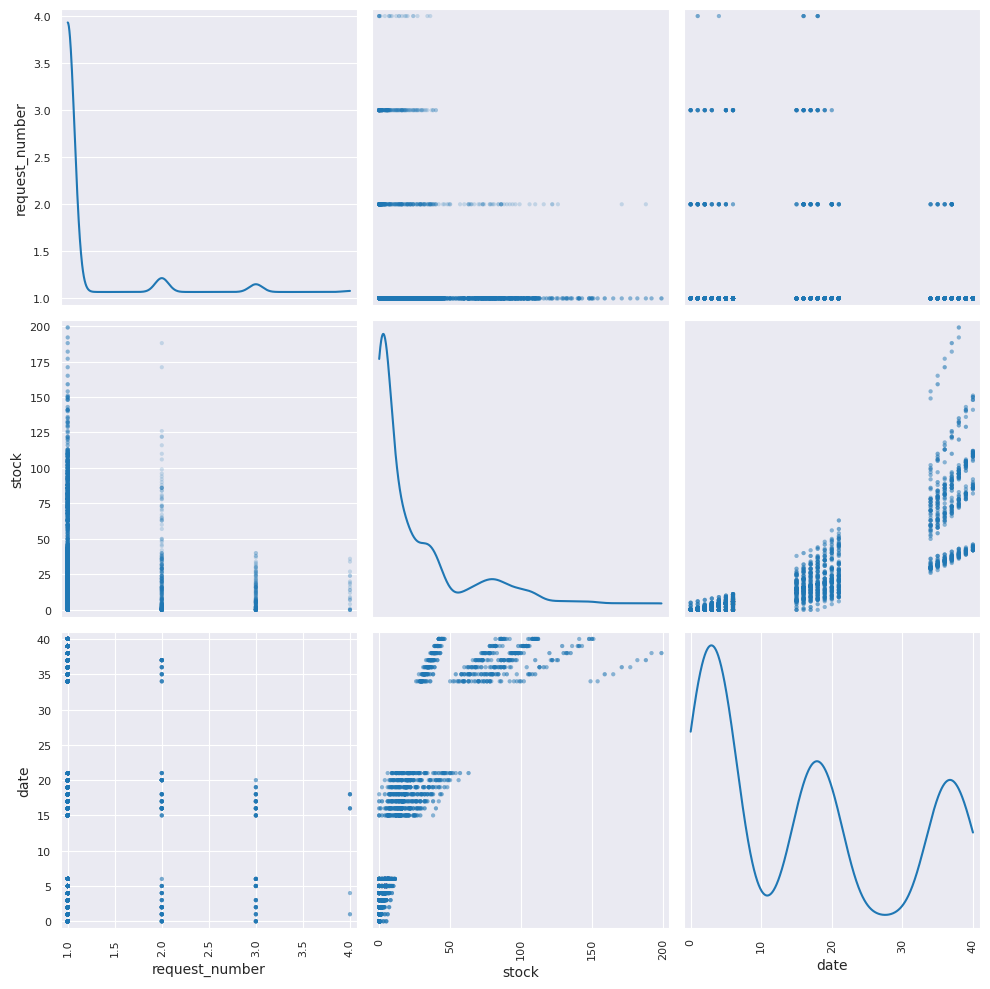

In [17]:
if prints :
    scatter_matrix(data_test[colQT[:-1]], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

# Transformations

In [45]:
transfo = False

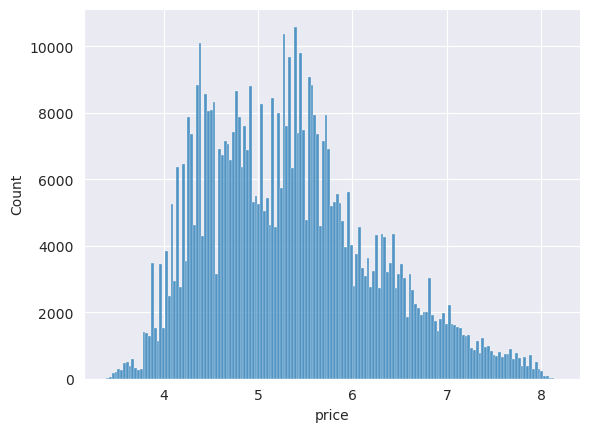

In [19]:
if prints :
    plt.figure()
    sns.histplot(data['price'].map(lambda x: x**(1/3)))
    plt.show()

In [20]:
if transfo :
    data['SRprice'] = data['price'].map(lambda x: x**(1/3))
    colQT[-1] = 'SRprice'

# Préparation des datasets 

In [21]:
dataDum = pd.get_dummies(data[colQL])
dataDum_test = pd.get_dummies(data_test[colQL])

In [22]:
if dataDum.shape[1] != dataDum_test.shape[1]:
    print('nombre de colonnes différent')

In [23]:
dataQT = data[colQT[:-1]]
dataQT_test = data_test[colQT[:-1]]

In [24]:
dataBool = data[colBool]
dataBool_test = data_test[colBool]

In [27]:
df = pd.concat([dataDum,dataQT, dataBool],axis=1)
df_test = pd.concat([dataDum_test,dataQT_test, dataBool_test],axis=1)
df.head()

,city_amsterdam,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_austrian,...,brand_Tripletree,children_policy_0,children_policy_1,children_policy_2,request_number,stock,date,mobile,pool,parking
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,49,32,1,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,49,32,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,5,1,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,64,36,1,0,1
5,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,53,33,0,0,1


In [29]:
# variable à expliquer
y = data[colQT[-1]]

# Séparation des données

In [31]:
submit = True

In [32]:
# séparation pour les tests et tunner les modèles
if submit :
    X_train = df
    X_test = df_test
    Y_train = y
    Y_test = None
else :
    X_train, X_test, Y_train, Y_test = train_test_split(df,y,test_size=.25,random_state=11) #25% pour le test_size

# Standardisation des données

In [33]:
stand = False

In [34]:
if stand :
    # standardisation des données
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_stand_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_stand_test = scaler.transform(X_test)

# Boosting

In [37]:
# définition des paramètres
boost = GradientBoostingRegressor()
# apprentissage
rfFit = boost.fit(X_train,Y_train)

In [38]:
if not submit:
# erreur de prédiction sur le test
    1-rfFit.score(X_test,Y_test)

In [39]:
# prédiction
y_pred = rfFit.predict(X_test)
if not submit:
    print("MSE =",mean_squared_error(y_pred,Y_test))
    print("R2 =",r2_score(Y_test,y_pred))

# Random Forest

In [ ]:
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,
                               max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, 
                               max_features=1.0, max_leaf_nodes=None,
                               bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

In [ ]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
if not submit:
# erreur de prévision sur le test
    1-rfOpt.score(X_test,Y_test)

In [ ]:
# prévision
y_pred = rfOpt.predict(X_test)
if not submit :
    print("MSE=",mean_squared_error(y_pred,Y_test))
    print("R2=",r2_score(Y_test,y_pred))

# Export submission

In [40]:
print(y_pred)

[4.95580991 5.34147964 4.11706452 ... 5.23925815 5.39139281 5.23925815]


In [44]:
# save
newY = y_pred
if transfo:
    newY = y_pred**3
if submit :
    sub = pd.DataFrame(newY)
    sub.to_csv(path + 'submit/Boosting_Transfo.csv',index=True, header=['price'], index_label = 'index')

# A faire

> analyser les stock

> ajouter une variable écart de temps

> fusionner children policy 1 et 2

> hotel_ID en QT

> transfos sur le prix

> transfos sur autres variables QT